# MONITOREO DE SEQUÍAS DESDE EL ESPACIO

##### Ing. Ag. Marcelo Bueno D.
24 de septiembre del 2023

#### Puntos clave


Ha sido demostrado que el contenido de agua del suelo es un indicador más directo de la disponibilidad de agua para los cultivos y es capaz de predecir el impacto de sequias en el rendimiento agrícola mejor que la precipitación ( Xia et al., 2014).

En países en vías de desarrollo como el Perú, se cuenta con escasa información de las propiedades y procesos del suelo a alta resolución espacio-temporal y por lo tanto es muy difícil disponer de esta para distintas aplicaciones (Rojas et al., 2017, p. 13); particularmente casi no existe a la fecha infraestructura de monitoreo de la humedad del suelo a largo plazo en países en vías de desarrollo (Brocca et al., 2017, p. 2).

Más aún, en el contexto del cambio climático existe más que nunca la necesidad de disponer de información continua y a largo plazo de la humedad del suelo (Dorigo & de Jeu, 2016, p. 3).

En zonas sin instrumentación la teledetección es una alternativa viable para obtener información de la humedad del suelo de alta resolución y casi en tiempo real.  


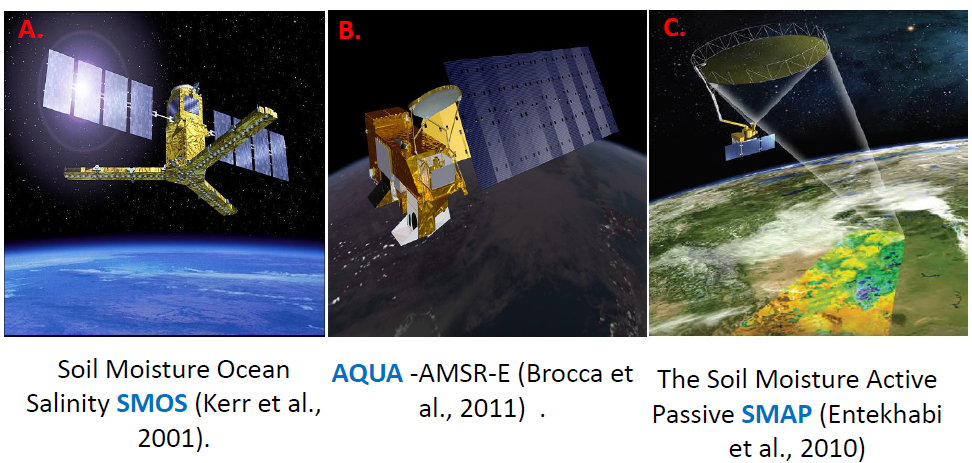

In [194]:
Image(filename='./img/satelites.PNG')

#### Qué es desagregacion? (downscaling)

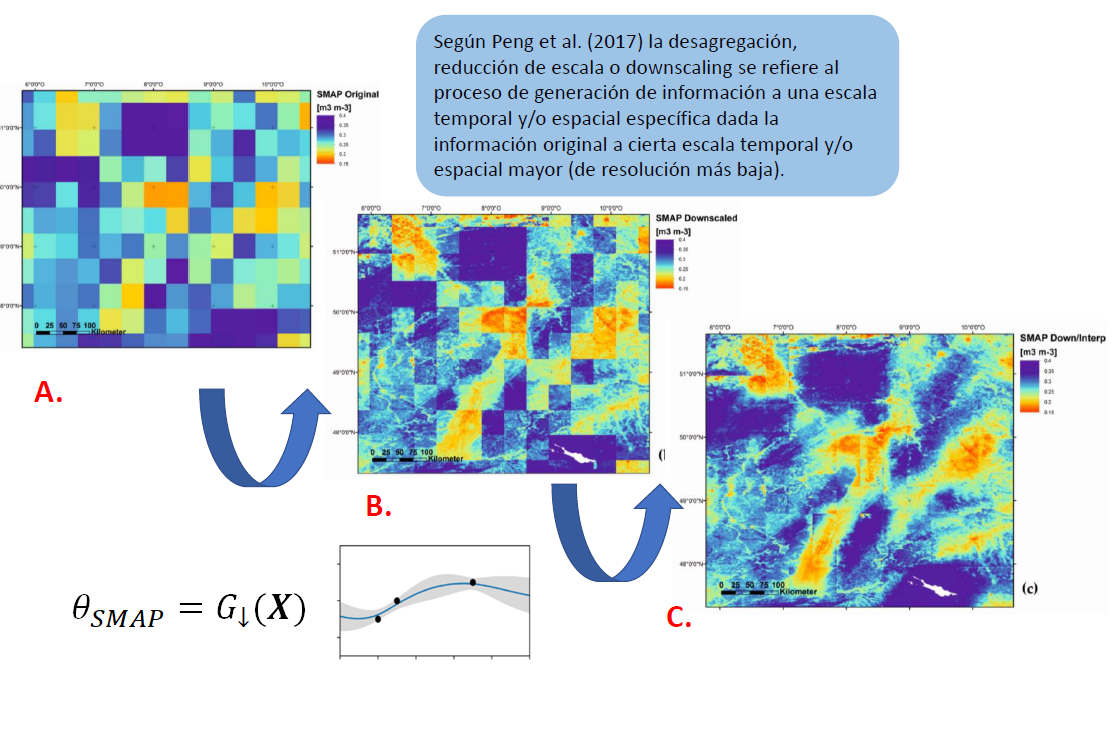

In [17]:
Image(filename='./img/downscaling.PNG')

La idea basica es la siguiente: si en este punto del espacio conozco la precipitacion, la pendiene, el contenido de materia organica, etc, puedo predeccir la humedad del suelo usando algun modelo estadistico?

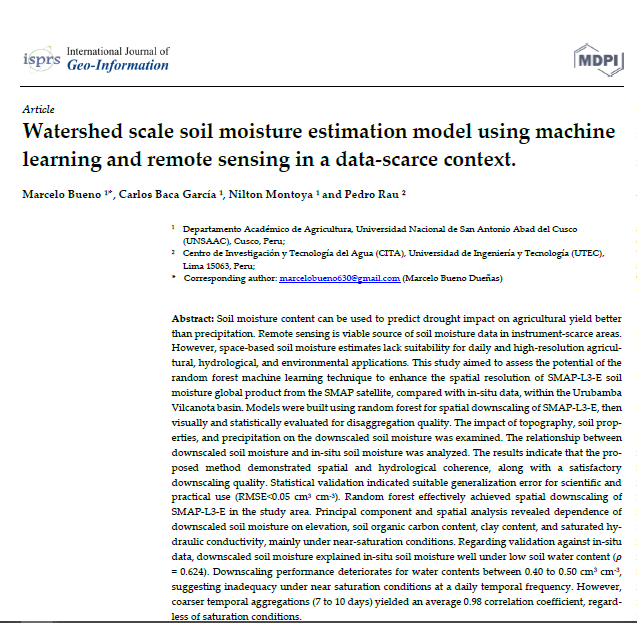

In [8]:
Image(filename='./img/paper.PNG')

### Area de estudio

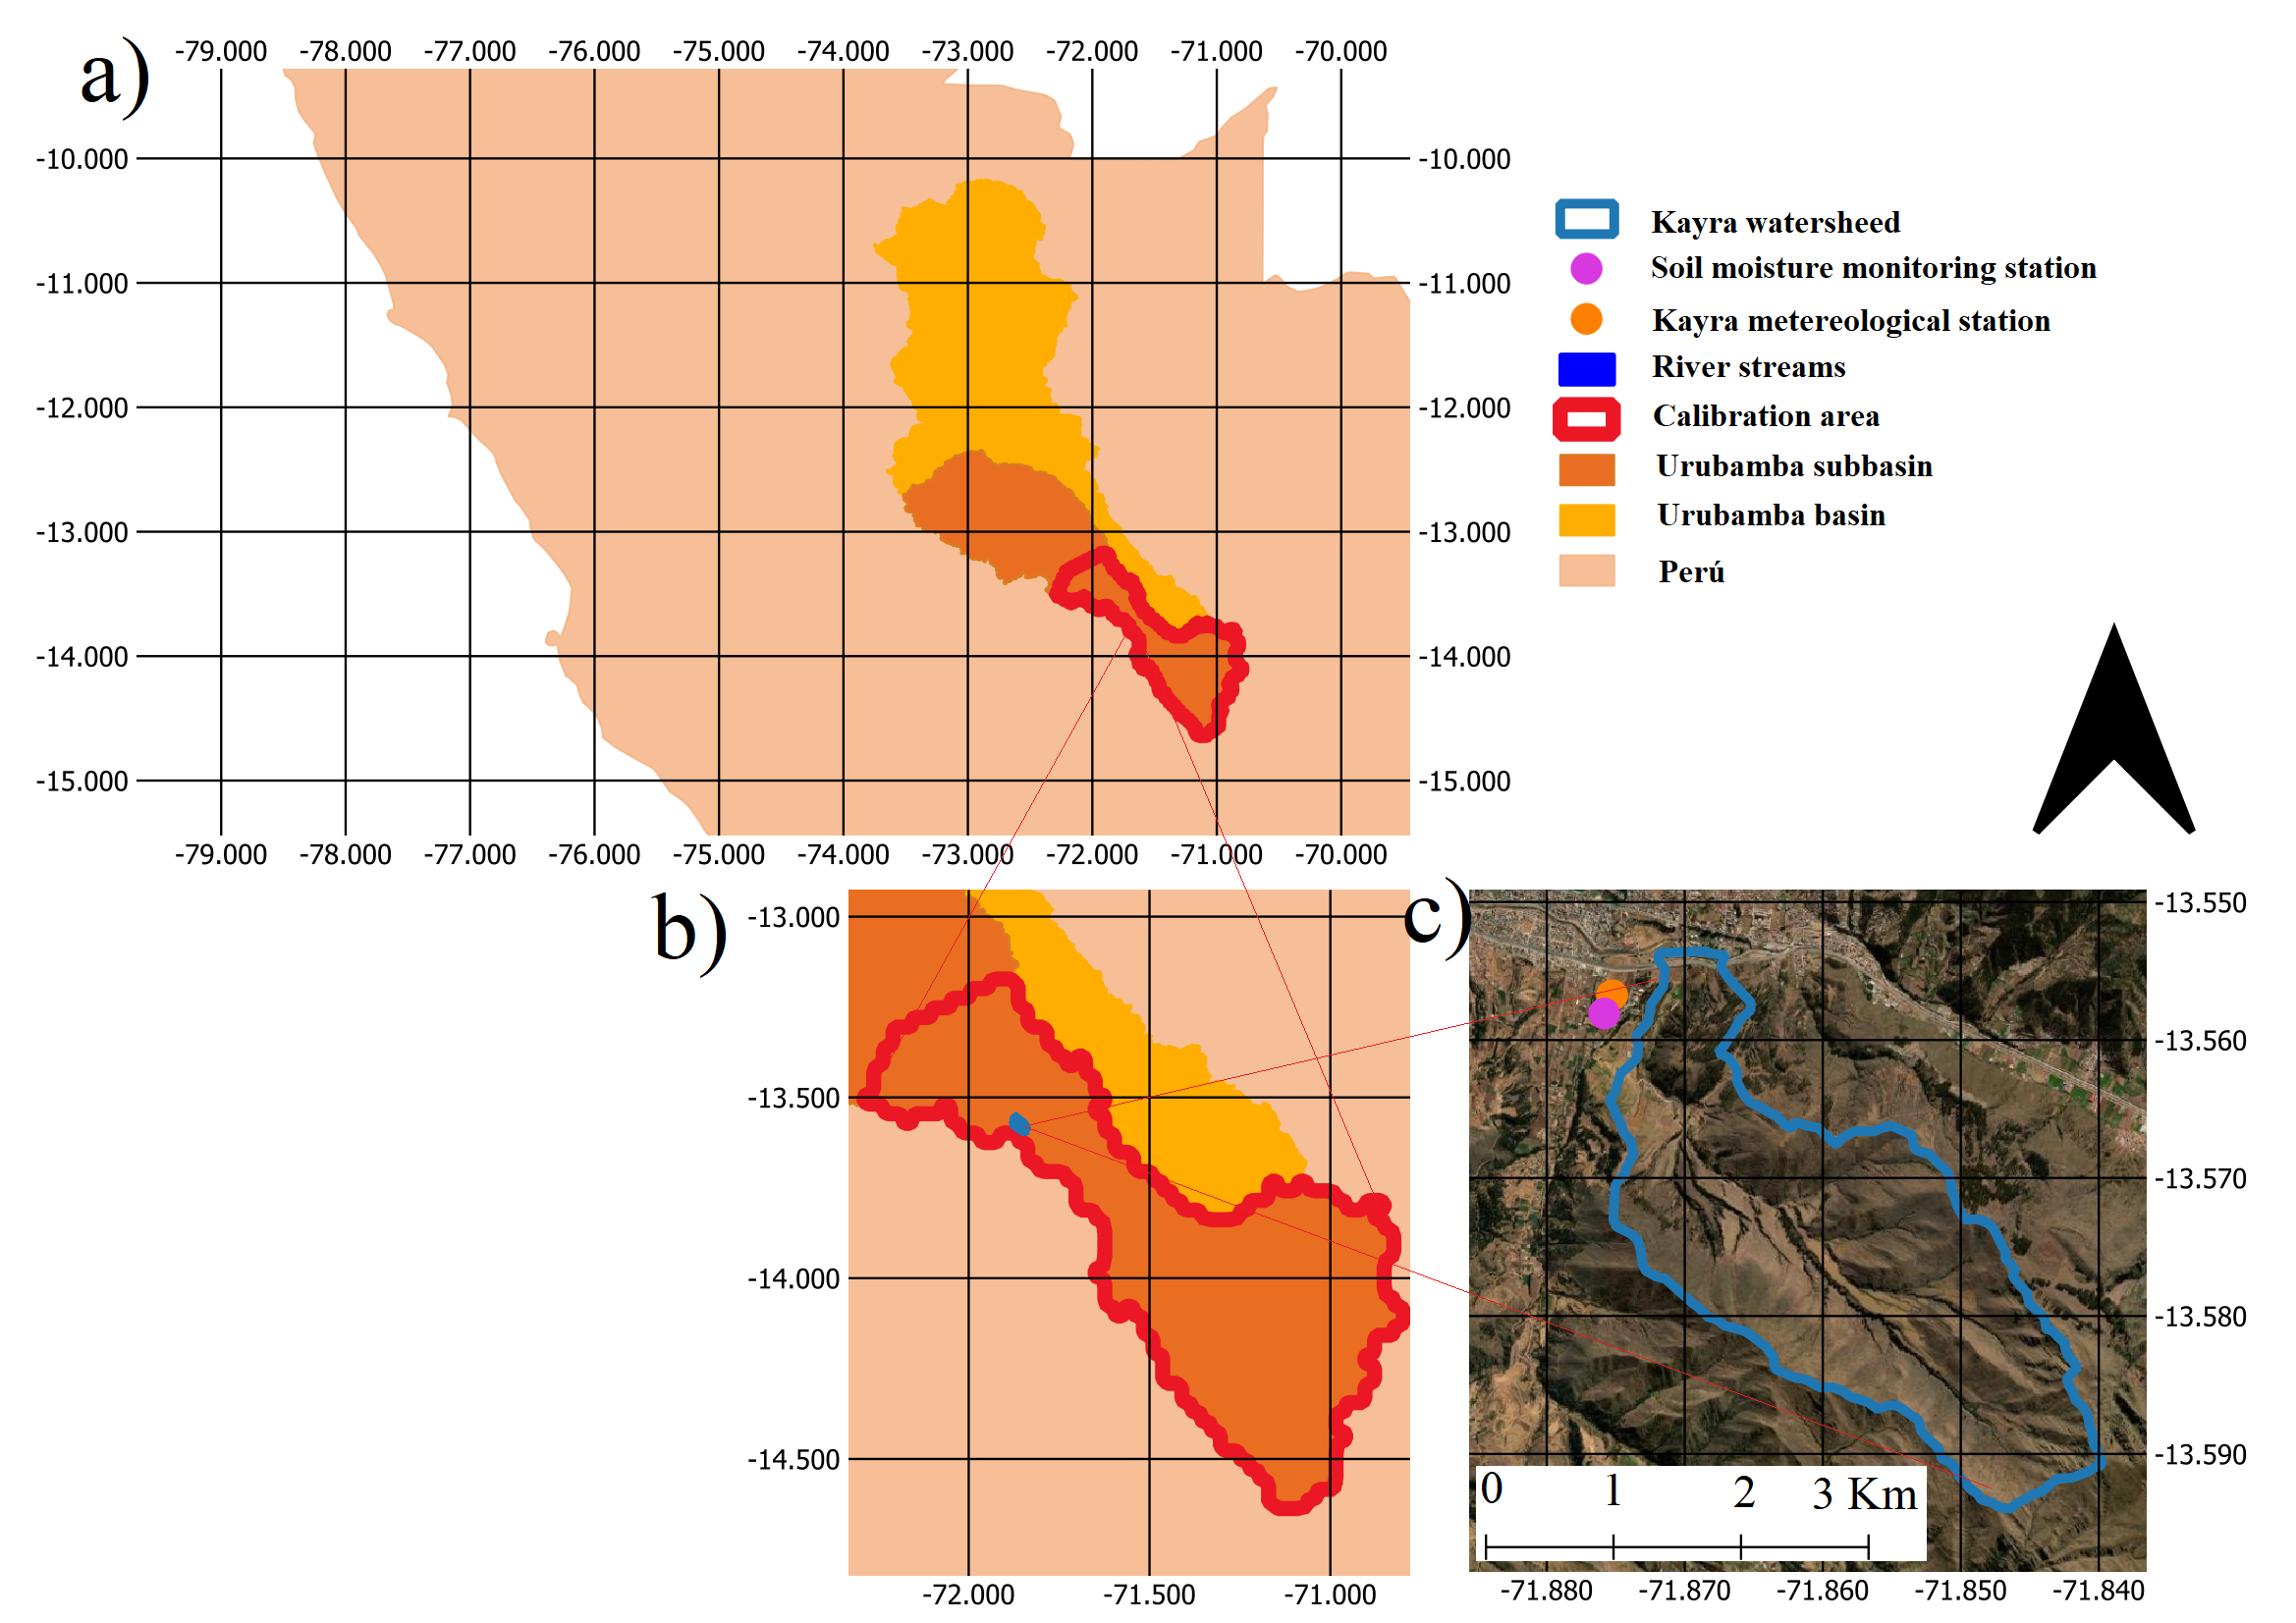

In [189]:
Image(filename='./img/mapa.png')

##### 1. Importar librerias

In [ ]:
#!pip install datasets optuna rasterio pyproj rioxarray

#### Cargar librerias para trabajar con objectos espaciales

In [30]:
import numpy as np
import os
import re 
import xarray as xr
import rioxarray as rxr
import pyproj
import rasterio
import pandas as pd
import geopandas
import shapely.geometry as sg
from shapely.geometry import Point
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
import datacube
from datetime import datetime, date, time, timedelta
import itertools
import random
from tqdm import tqdm

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import folium



#### Cargar librerias para machine learning

In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# from openpyxl import Workbook


#### 2. Directorio de la data

In [6]:
path = pathlib.Path()
path = path.resolve()
path

WindowsPath('D:/DOCS/CIENCIA DE SUELOS/R_SUELOS/soil_moisture_smap/smap_code')

#### Cargar data de smap (Fechas entre 2021 y 2022)

In [9]:
# LOAD SMAP NCDF
data_directory = path / 'data' / 'input' / 'smap_3km' / 'smap.nc'
smap_dataset = xr.open_dataset(data_directory) 
smap_dataset

<xarray.Dataset>
Dimensions:      (time: 213, y: 54, x: 57)
Coordinates:
  * x            (x) float64 -72.4 -72.37 -72.34 -72.31 ... -70.72 -70.69 -70.66
  * y            (y) float64 -13.13 -13.16 -13.2 -13.23 ... -14.72 -14.75 -14.78
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 2021-01-01 2021-01-04 ... 2022-07-28
Data variables:
    s_moisture   (time, y, x) float32 ...

In [14]:
smap_available_dates = pd.to_datetime(smap_dataset['time'].values)
smap_available_dates
smap_available_dates_df = pd.DataFrame({'Date': smap_available_dates})
smap_available_dates_df.head()

Date
0 2021-01-01
1 2021-01-04
2 2021-01-06
3 2021-01-09
4 2021-01-12

#### Cargar covariables

In [18]:
# LOAD COVS 3 KM 
data_directory = path / 'data' / 'input' / 'covs_3km'  / 'covs.nc'
covs_dataset = xr.open_dataset(data_directory) 
covs_dataset

<xarray.Dataset>
Dimensions:        (band: 1, y: 54, x: 57)
Coordinates:
  * band           (band) int32 1
  * x              (x) float64 -72.4 -72.37 -72.34 ... -70.72 -70.69 -70.66
  * y              (y) float64 -13.13 -13.16 -13.2 ... -14.72 -14.75 -14.78
Data variables: (12/15)
    arcilla_0_5cm  (band, y, x) float32 ...
    arena_0_5cm    (band, y, x) float32 ...
    cec_0_5cm      (band, y, x) float32 ...
    DEM            (band, y, x) float32 ...
    da_0_5cm       (band, y, x) float32 ...
    Ksat_1Km       (band, y, x) float32 ...
    ...             ...
    pisco_JJA      (band, y, x) float32 ...
    pisco_MAM      (band, y, x) float32 ...
    pisco_SON      (band, y, x) float32 ...
    twi_fd8_mfd    (band, y, x) float32 ...
    twi_mfd_md     (band, y, x) float32 ...
    spatial_ref    int32 ...

##### MAPA DE COVARIABLES

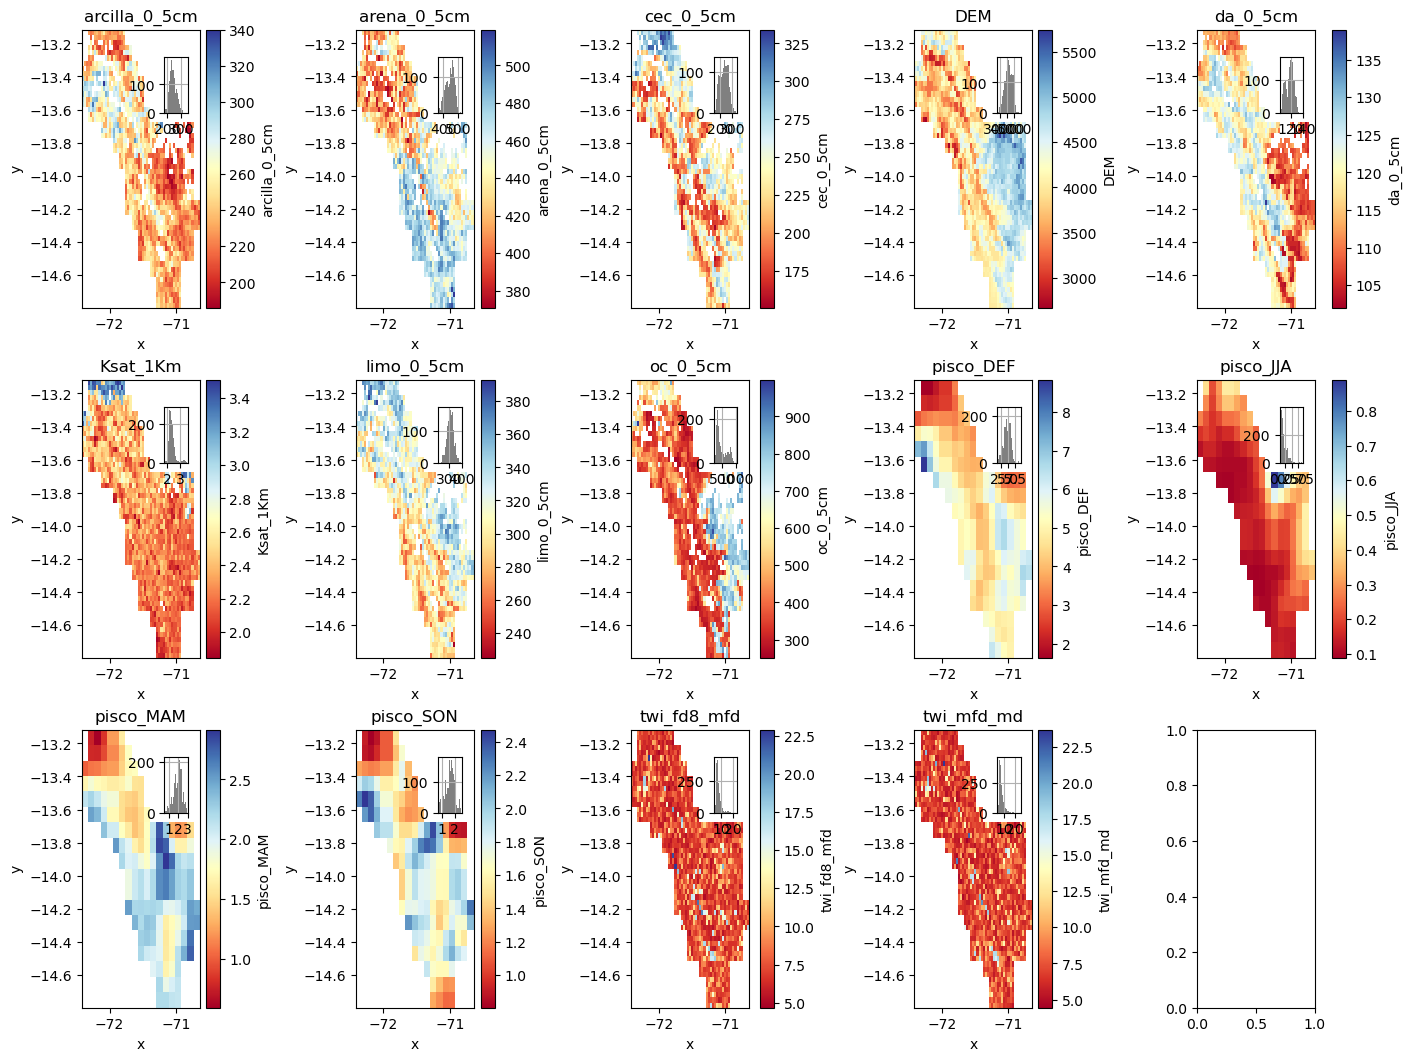

In [14]:
covs_to_plot = ['arcilla_0_5cm','arena_0_5cm','cec_0_5cm',
        'DEM','da_0_5cm','Ksat_1Km','limo_0_5cm','oc_0_5cm','pisco_DEF',
        'pisco_JJA','pisco_MAM','pisco_SON','twi_fd8_mfd','twi_mfd_md']


data_arrays = [covs_dataset[var_name].squeeze() for var_name in covs_to_plot]

N=len(covs_to_plot)
cols = 5

from math import ceil

fig, axs = plt.subplots( ncols=cols, nrows=ceil(N/cols), layout='constrained',
                         figsize=(3.5 * 4, 3.5 * ceil(N/cols)) )

for index, ax in enumerate(axs.flat):
        if index < N:  
                raster = data_arrays[index]
                im = raster.plot(ax=ax, cmap='RdYlBu')
                filename = covs_to_plot[index]
                ax.set_title(filename)
                
                # histogram inset
                ax_hist = ax.inset_axes([0.7, 0.7, 0.2, 0.2])  
                hist_values, hist_bins, _ = ax_hist.hist(raster.values.flatten(), bins=20, color="gray")
                ax_hist.grid() 

plt.show()


##### Metodología

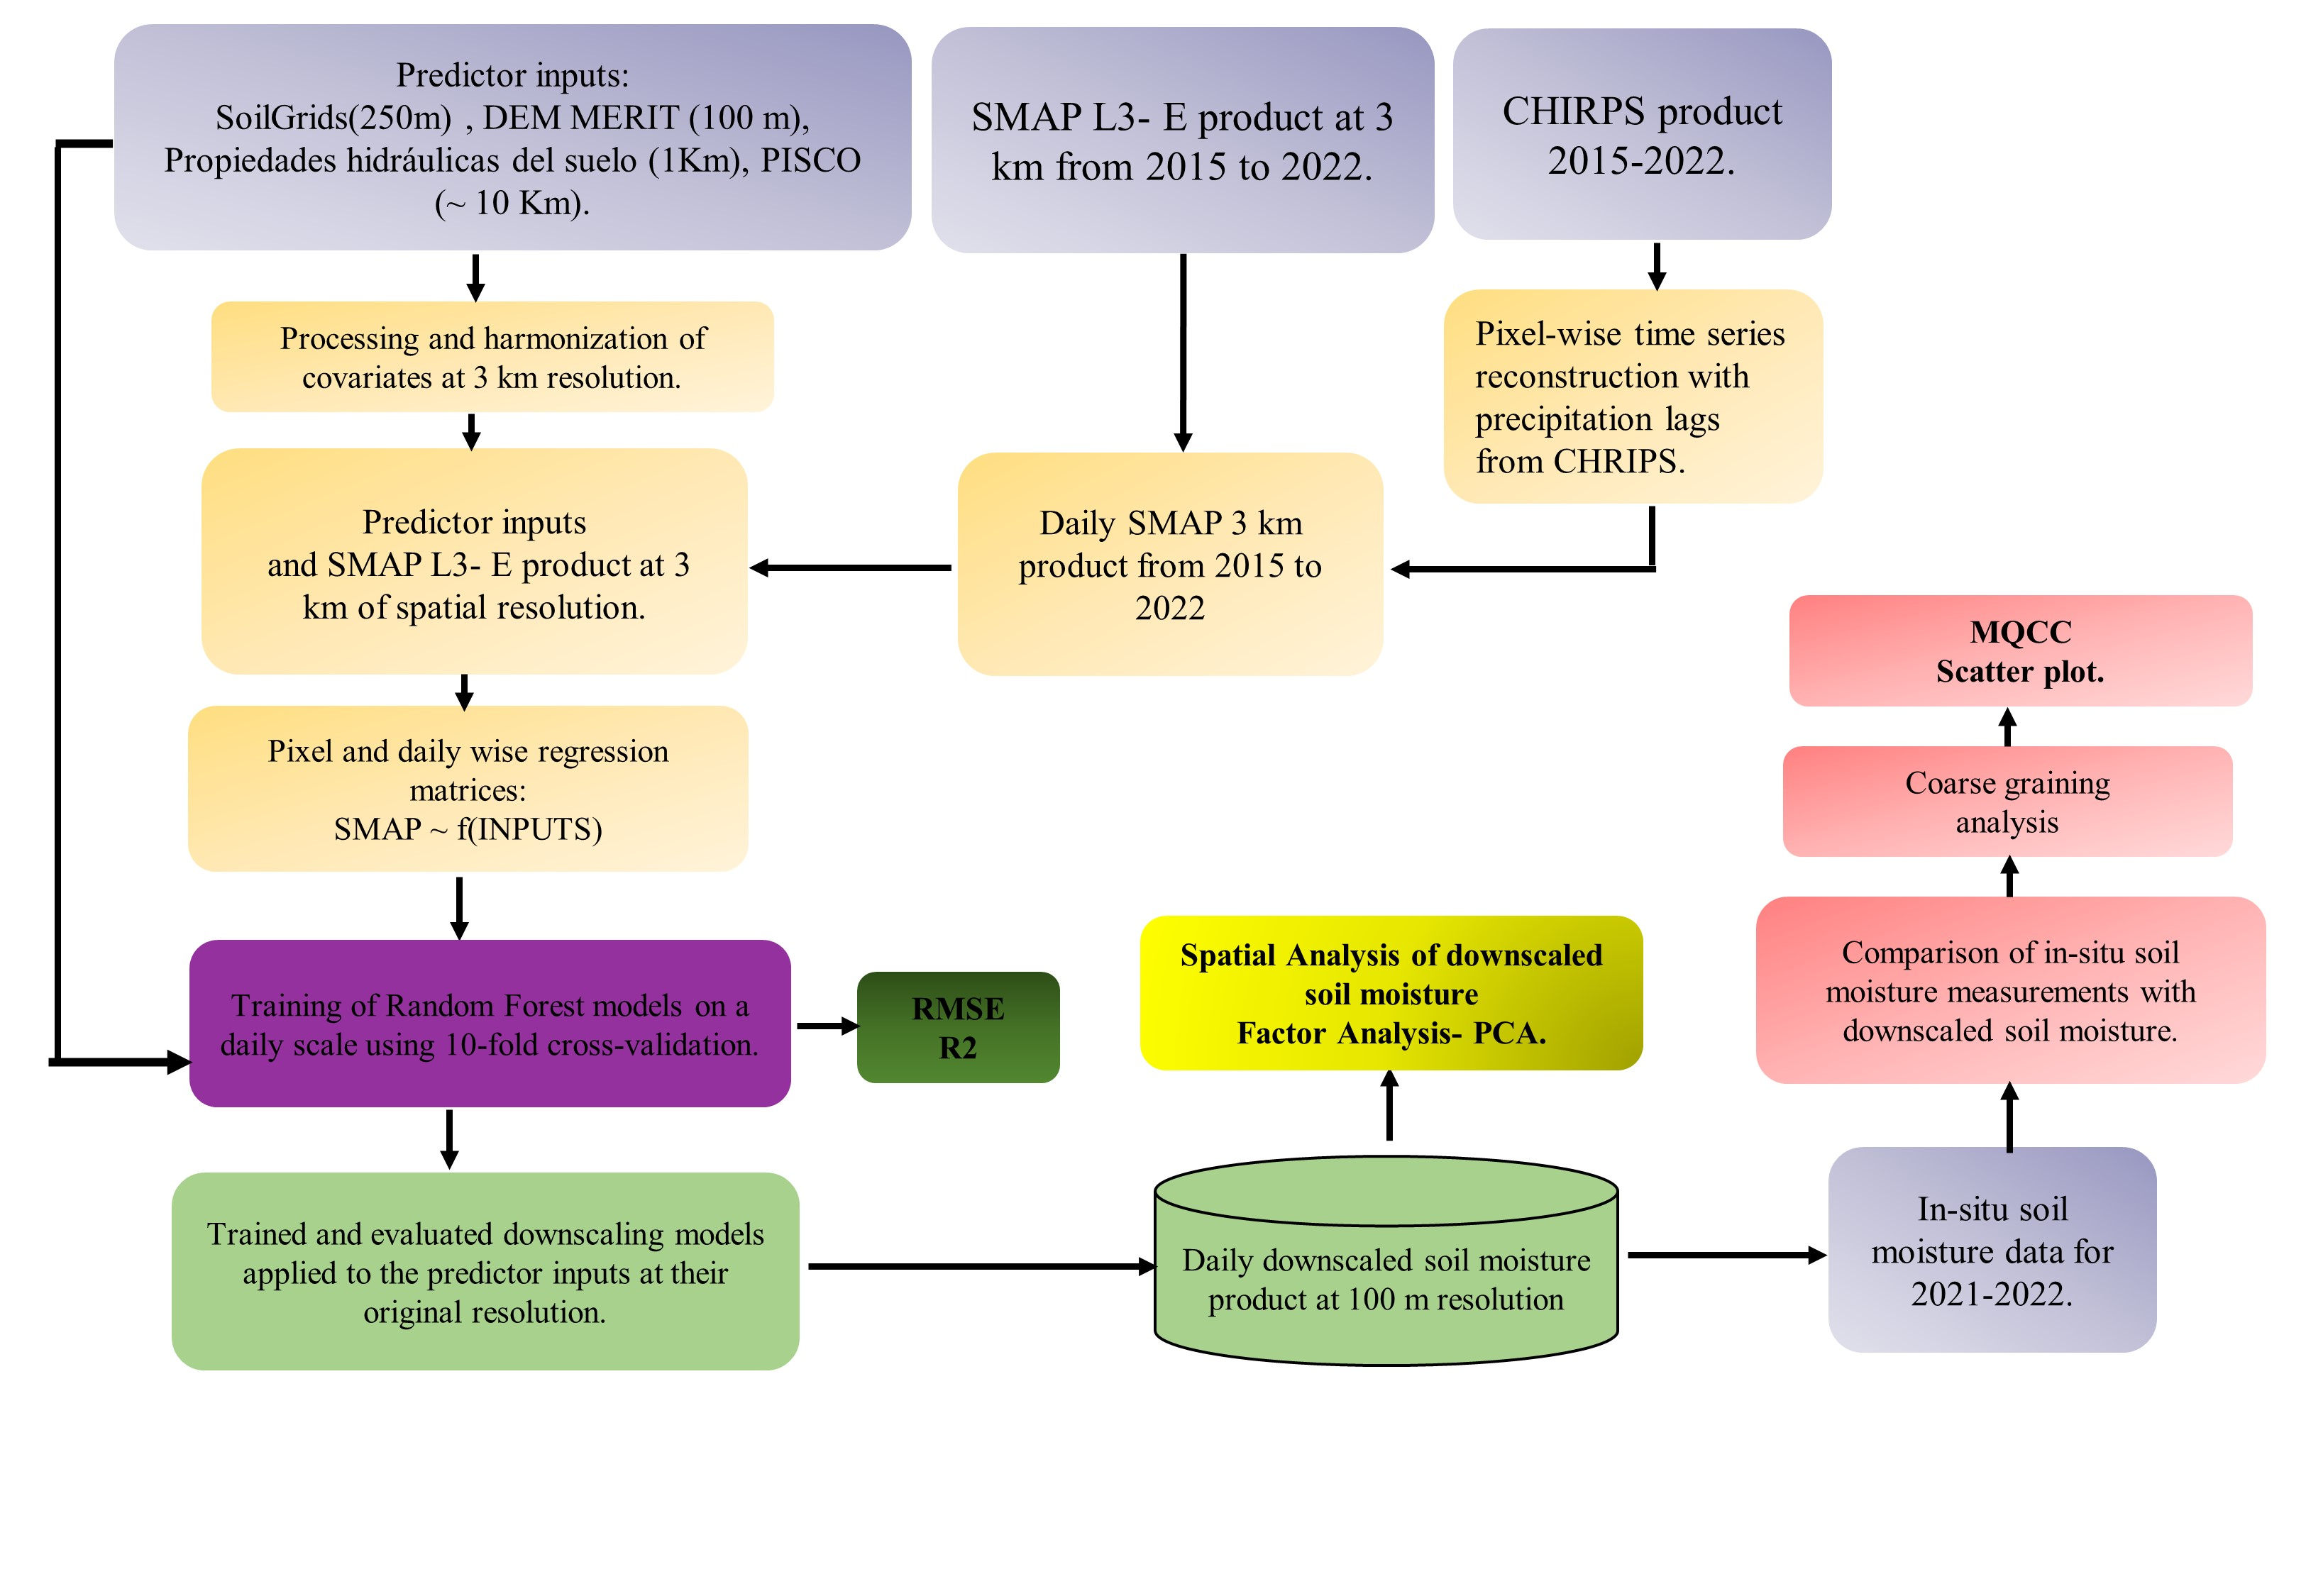

In [190]:
Image(filename='./img/fig3.jpg')

Generacion de matrices de regresion

In [19]:
covs_df = covs_dataset.to_dataframe().reset_index()

selected_features = ['s_moisture','arcilla_0_5cm','arena_0_5cm','cec_0_5cm',
        'DEM','da_0_5cm','Ksat_1Km','limo_0_5cm','oc_0_5cm','pisco_DEF',
        'pisco_JJA','pisco_MAM','pisco_SON','twi_fd8_mfd','twi_mfd_md']

dfs = []
for time_step in smap_dataset['time']:
    smap_data = smap_dataset.sel(time=time_step).to_dataframe().reset_index()
    merged_data = pd.merge(smap_data, covs_df, on=['x', 'y'], how='left')
    merged_data = merged_data[selected_features]
    merged_data = merged_data.dropna()
    dfs.append(merged_data)

dfs[0].head()

s_moisture  arcilla_0_5cm  arena_0_5cm  cec_0_5cm          DEM  da_0_5cm  \
3    0.473591          228.0        429.0      270.0  4456.502930     113.0   
4    0.473591          219.0        398.0      252.0  4457.816895     114.0   
5    0.473591          223.0        413.0      290.0  4226.814453     113.0   
6    0.457591          233.0        400.0      269.0  4356.754395     113.0   
7    0.457591          238.0        422.0      268.0  4336.574219     113.0   

   Ksat_1Km  limo_0_5cm  oc_0_5cm  pisco_DEF  pisco_JJA  pisco_MAM  pisco_SON  \
3  3.460723       370.0     523.0   1.654155   0.405228   0.757415   0.911073   
4  3.176538       365.0     494.0   1.654155   0.405228   0.757415   0.911073   
5  3.442540       359.0     560.0   1.654155   0.405228   0.757415   0.911073   
6  3.416717       364.0     559.0   1.632063   0.208952   0.590887   0.804268   
7  3.270494       339.0     535.0   1.632063   0.208952   0.590887   0.804268   

   twi_fd8_mfd  twi_mfd_md  
3     8.660512    6.967535  
4     6.810773    6.065683  
5     7.913556    6.197326  
6     6.705589   12.232630  
7     6.778638    6.992006

Analisis exploratorio simple

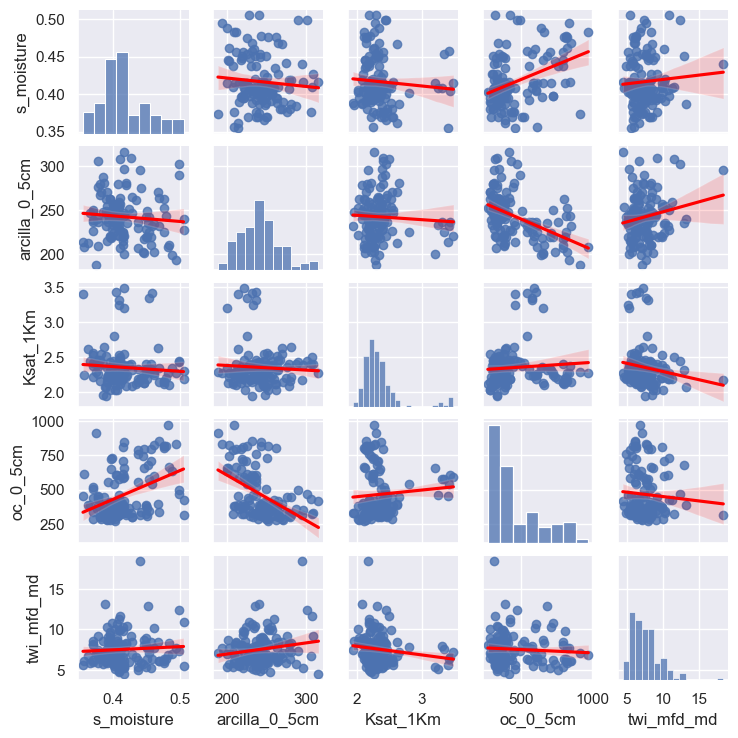

In [47]:
# SCATTER PLOTS

data_plot = dfs[0]
data_plot = data_plot[['s_moisture','arcilla_0_5cm','Ksat_1Km','oc_0_5cm','twi_mfd_md']].sample(frac=0.1)

sns.set()
sns.pairplot(data_plot, kind='reg', plot_kws={'line_kws': {'color': 'red'}}, height=1.5)  # Adjust the height parameter
plt.show()


#### MODELAMIENTO DE LA HUMEDAD DEL SUELO

Metrica de validacion (RMSE)

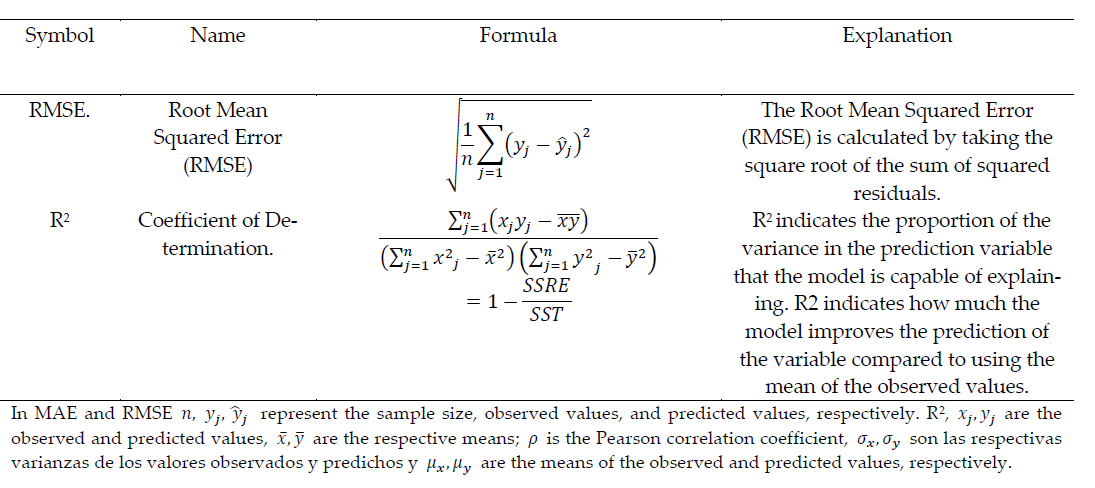

In [196]:
Image(filename='./img/rmse.PNG')

In [21]:
# ERROR METRIC RMSQ # INSERTAR IMAGEN

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Entrenamiento de modelos de machine learning como metodo de desagregacion


In [22]:
RANDOM_STATE = 42
TEST_RATIO = 0.2

# MODELO 

downscaling_models = []
rmse_values = [] 
for data in tqdm(dfs):  

    X_lrn, X_test, y_lrn, y_test = train_test_split(
        data.drop(['s_moisture'], axis='columns'),
        data['s_moisture'],
        random_state=RANDOM_STATE,
        train_size=1-TEST_RATIO)
    
    xgb_reg = XGBRegressor(
    n_estimators=200, 
    learning_rate=0.01,  
    max_depth=50,  
    alpha =0.001,  # L1 regularization 
    objective ='reg:squarederror',  
    eval_metric ='rmse'
    )

    xgb_reg.fit(X_lrn, y_lrn, verbose =0)

    downscaling_models.append(xgb_reg)
    y_pred = xgb_reg.predict(X_test)

    test_rmse = rmse(y_pred,y_test)
    rmse_values.append(test_rmse)


  0%|          | 0/213 [00:00<?, ?it/s]

100%|██████████| 213/213 [08:12<00:00,  2.31s/it]


In [25]:
results_df = pd.DataFrame({'Downscaling Model': downscaling_models, 'RMSE': rmse_values})
results_df['Date'] = smap_available_dates_df['Date']
results_df.head()

Downscaling Model      RMSE       Date
0  XGBRegressor(alpha=0.001, base_score=None, boo...  0.022323 2021-01-01
1  XGBRegressor(alpha=0.001, base_score=None, boo...  0.017890 2021-01-04
2  XGBRegressor(alpha=0.001, base_score=None, boo...  0.018378 2021-01-06
3  XGBRegressor(alpha=0.001, base_score=None, boo...  0.019148 2021-01-09
4  XGBRegressor(alpha=0.001, base_score=None, boo...  0.018489 2021-01-12

Error de desagreagacion

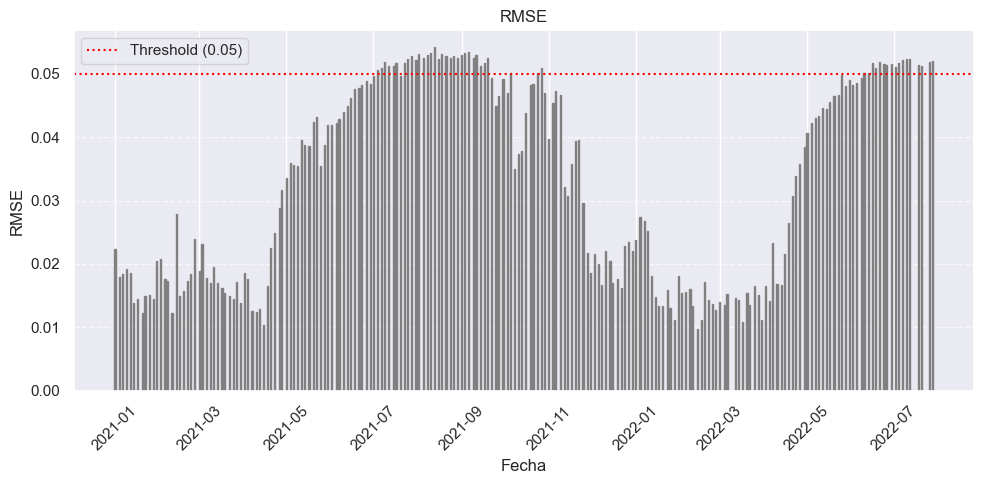

In [48]:
plt.figure(figsize=(10, 5))  

plt.bar(results_df['Date'], results_df['RMSE'], color='gray', edgecolor='gray')
plt.axhline(y=0.05, color='red', linestyle='dotted', label='Threshold (0.05)')
plt.title('RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.xticks(rotation=45) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()

##### Cuenca de prediccion

Cagar shapes de la cuenca y de los puntos de monitereo

In [28]:
# CUENCA

kayra_shapefile_directory = path / 'data' / 'input' / 'kayra_watershed' / 'kayra.shp'  
# kayra_shapefile_directory
kayra_shapefile = geopandas.read_file(kayra_shapefile_directory)

# ESTACION DE MONITOREO

station_shapefile_directory = path / 'data' / 'input' / 'thetaprobe' / 'estacion_kayra_monitoreo.shp'  
# kayra_shapefile_directory
station_shapefile = geopandas.read_file(station_shapefile_directory)


Mapa de la subcuenca de prediccion

In [31]:
mean_lat = (kayra_shapefile.geometry.centroid.y.mean() + station_shapefile.geometry.centroid.y.mean()) / 2
mean_lon = (kayra_shapefile.geometry.centroid.x.mean() + station_shapefile.geometry.centroid.x.mean()) / 2

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=14)

folium.GeoJson(kayra_shapefile).add_to(m)
folium.GeoJson(station_shapefile).add_to(m)

for idx, row in station_shapefile.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],  
        icon=folium.Icon(color='red')  
    ).add_to(m)


folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite',
    overlay=False,
    control=True
).add_to(m)


folium.LayerControl().add_to(m)

m.save('interactive_map.html')
m

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10252\1749955022.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_lat = (kayra_shapefile.geometry.centroid.y.mean() + station_shapefile.geometry.centroid.y.mean()) / 2
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10252\1749955022.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_lat = (kayra_shapefile.geometry.centroid.y.mean() + station_shapefile.geometry.centroid.y.mean()) / 2
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10252\1749955022.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mean_lon = (kayra_sha

#### Ahora generamos humedad del suelo a alta resolucion en la cuenca

Covariables predictivas a 100 m para la subcuenca Kayra

In [34]:
covs100_directory = path / 'data' / 'input' / 'covs_100m'  / 'covs_100_kayra.nc'
covs_100_kayra = xr.open_dataset(covs100_directory) 
covs_100_kayra

<xarray.Dataset>
Dimensions:        (band: 1, x: 42, y: 49)
Coordinates:
  * band           (band) int32 1
  * x              (x) float64 -71.87 -71.87 -71.87 ... -71.84 -71.84 -71.84
  * y              (y) float64 -13.55 -13.55 -13.56 ... -13.59 -13.59 -13.59
Data variables: (12/15)
    spatial_ref    int32 ...
    arcilla_0_5cm  (band, y, x) float32 ...
    arena_0_5cm    (band, y, x) float32 ...
    cec_0_5cm      (band, y, x) float32 ...
    DEM            (band, y, x) float32 ...
    da_0_5cm       (band, y, x) float32 ...
    ...             ...
    pisco_DEF      (band, y, x) float32 ...
    pisco_JJA      (band, y, x) float32 ...
    pisco_MAM      (band, y, x) float32 ...
    pisco_SON      (band, y, x) float32 ...
    twi_fd8_mfd    (band, y, x) float32 ...
    twi_mfd_md     (band, y, x) float32 ...

Desagregacion de la humedad del suelo a 100 m de resolucion usando las covariables , generacion de mapas

In [36]:


selected_features = ['arcilla_0_5cm','arena_0_5cm','cec_0_5cm',
        'DEM','da_0_5cm','Ksat_1Km','limo_0_5cm','oc_0_5cm','pisco_DEF',
        'pisco_JJA','pisco_MAM','pisco_SON','twi_fd8_mfd','twi_mfd_md']

dims = covs_100_kayra.to_array().shape
# first_10_rows = results_df.head(2) # modelos 

downscaled_list = []

for _, row in results_df.iterrows(): 
        downscaler_model = row[0] # modelo
        dataset_array = covs_100_kayra[selected_features].to_array().values 
        dataset_array = np.squeeze(dataset_array, axis=1) # delete band dimension
        transposed_data = dataset_array.transpose(1, 2, 0) 
        reshaped_data = transposed_data.reshape((dims[2]*dims[3], len(selected_features))) #   npixels vs n feaures
        data_df = pd.DataFrame(reshaped_data, columns=selected_features, dtype=np.float32) 

        data_df.fillna(-999, inplace=True)
        predictions_flat = downscaler_model.predict(data_df)

        # df to raster
        prediction_2d = predictions_flat.reshape((dims[2],dims[3]))
        y = covs_100_kayra.coords['y'].values
        x = covs_100_kayra.coords['x'].values
        prediction_xr = xr.DataArray(prediction_2d, coords={'y':y, 'x':x})

        # mask predicitions
        na_mask = np.isnan(covs_100_kayra['arcilla_0_5cm'])
        na_mask = np.squeeze(na_mask, axis=0)
        prediction_xr_ = prediction_xr.where(~na_mask)
        downscaled_list.append(prediction_xr_)

date_array = smap_available_dates_df['Date'].to_numpy(dtype='datetime64')
downscaled_smap_cuenca = xr.concat(downscaled_list, dim="time").assign_coords(time=date_array)



Mapa de humedad del suelo a alta resolucion

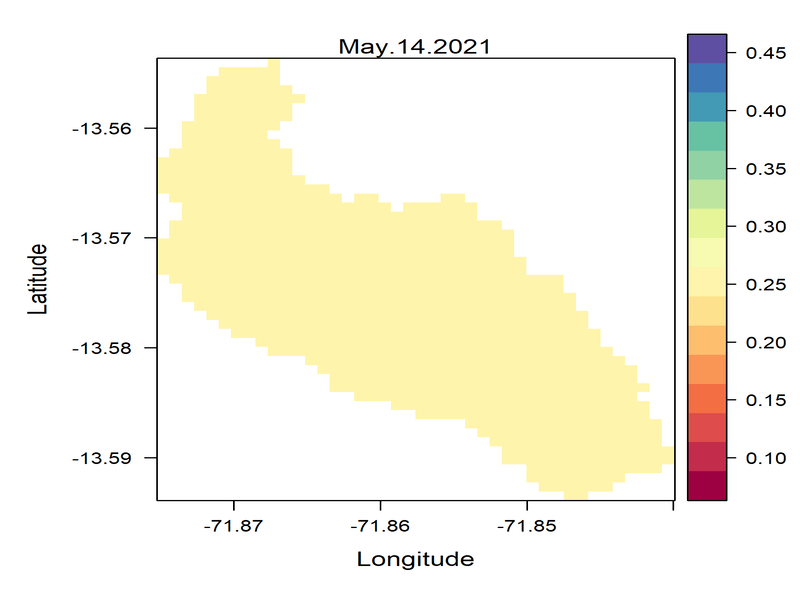

In [37]:
Image(filename='animation_smooth_final001.gif')

In [123]:
# SAVE 
# smap_output_path = path / 'data' / 'output' / 'smap_predictions_100m'  / 'smap_100_cuenca.nc'
# downscaled_smap_cuenca.to_netcdf(smap_output_path) 

Extraemos la data de humedad del suelo desagreagada para un punto de monitoreo para comparar con monitoreo

In [41]:
smap_down_df = pd.DataFrame()

for index, row in station_shapefile.iterrows():
    lon, lat = row['geometry'].x, row['geometry'].y
    values = downscaled_smap_cuenca.sel(x=lon, y=lat, method='nearest')
    column_label = f"the_down_{row['id']}"
    smap_down_df[column_label] = values

smap_down_df['Date'] = pd.to_datetime(downscaled_smap_cuenca.time.values)
# smap_down_df.set_index('Date', inplace=True)
smap_down_df = smap_down_df[['Date', 'the_down_1']]
smap_down_df.head()

Date  the_down_1
0 2021-01-01    0.420509
1 2021-01-04    0.465461
2 2021-01-06    0.434349
3 2021-01-09    0.433313
4 2021-01-12    0.473841

#### Monitoreo de la humedad en campo

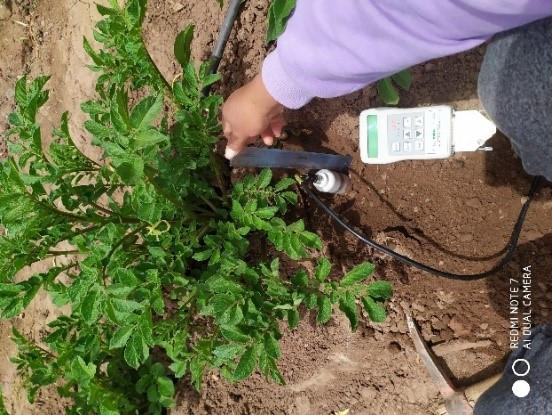

In [49]:
Image(filename='./img/sensor.jpg')

Cargar la data de monitoreo con sensor

In [42]:
monitoreo_directory = path / 'data' / 'input' / 'thetaprobe' / 'monitoreo.xlsx'
obs_df = pd.read_excel(monitoreo_directory)
obs_df.head()

Date  the_obs
0 2021-05-13    0.166
1 2021-05-14    0.227
2 2021-05-15    0.264
3 2021-05-16    0.273
4 2021-05-17    0.357

Unir ambos datos

In [43]:
validation_df = obs_df.merge(smap_down_df, on='Date', how='inner') # unimos los dos datasets
validation_df

Date  the_obs  the_down_1
0   2021-05-14    0.227    0.254276
1   2021-05-17    0.357    0.274179
2   2021-05-20    0.239    0.253120
3   2021-05-22    0.171    0.246025
4   2021-05-25    0.282    0.307758
..         ...      ...         ...
143 2022-06-21    0.130    0.174179
144 2022-06-24    0.141    0.181214
145 2022-06-26    0.098    0.180340
146 2022-06-29    0.147    0.181582
147 2022-07-02    0.130    0.178185

[148 rows x 3 columns]

#### Diagramas de validacion

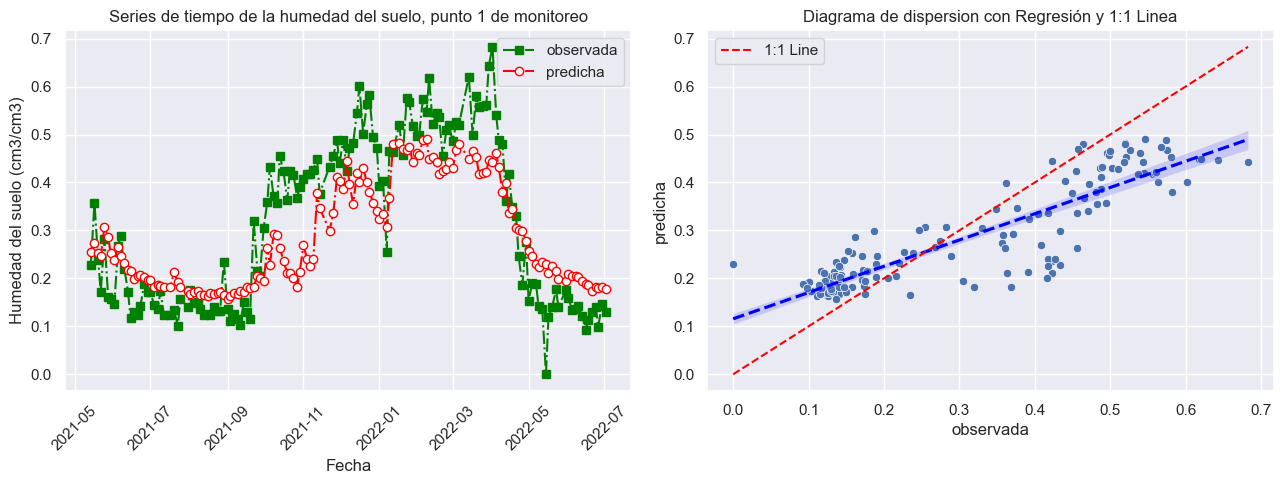

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# DIAGRAMAS DE TIEMPO

axes[0].plot(validation_df['Date'], validation_df['the_obs'], label='observada', color='green', marker='s', linestyle='-.')
axes[0].plot(validation_df['Date'], validation_df['the_down_1'], label='predicha', color='red', marker='o', linestyle='-.', markerfacecolor='white', markeredgecolor='red')

axes[0].set_title('Series de tiempo de la humedad del suelo, punto 1 de monitoreo')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Humedad del suelo (cm3/cm3)')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# DIAGRAMAS DE DISPERSION

sns.scatterplot(data=validation_df, x='the_obs', y='the_down_1', ax=axes[1])
sns.regplot(data=validation_df, x='the_obs', y='the_down_1', ax=axes[1], scatter=False, color='blue', line_kws={'linestyle': '--'})
axes[1].plot([validation_df['the_obs'].min(), validation_df['the_obs'].max()],
            [validation_df['the_obs'].min(), validation_df['the_obs'].max()],
            color='red', linestyle='--', label='1:1 Line')
axes[1].set_title('Diagrama de dispersion con Regresión y 1:1 Linea')
axes[1].set_xlabel('observada')
axes[1].set_ylabel('predicha')
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# subir cc y pmp de la zona de estudio


# aplicar ecuacion sequia
# grafica final de solo las fehcas de posible reisgo de seaui por plantas
# heat map??

##### Monitoreo de sequias a alta resolucion espacial

El SWDI se utiliza para monitorear las condiciones de sequía mediante la medición del déficit de humedad del suelo y está relacionado con estimaciones de humedad del suelo y propiedades del suelo asociadas (Martínez-Fernández et al., 2015; Mishra et al., 2017). El SWDI es importante para monitorear y cuantificar eventos de sequía. En este estudio, solo consideramos la extracción del SWDI en la capa superficial del suelo de 0 a 5 cm utilizando datos de humedad del suelo SMAP desagregada a una resolución de 100 km. El SWDI se calcula mediante la ecuación.

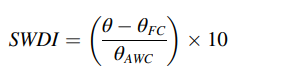

In [23]:

Image(filename='./img/swdi.PNG')


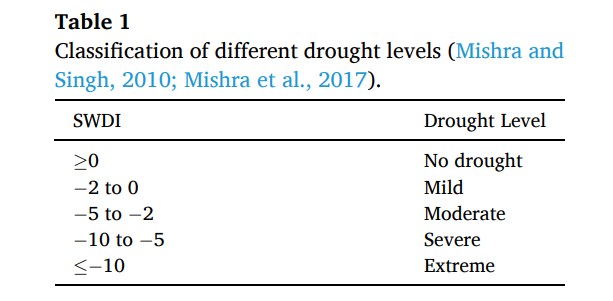

In [24]:
Image(filename='./img/niveles_sequia_fang.PNG')

### Necesitamos obtener informacion hidrológica del suelo

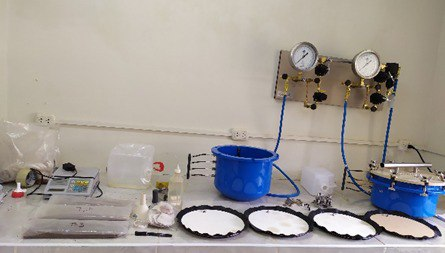

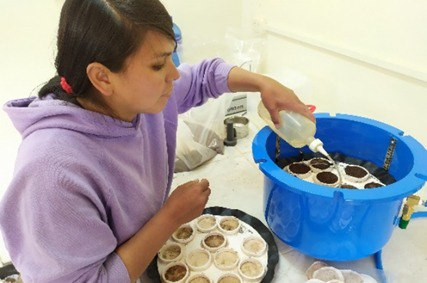

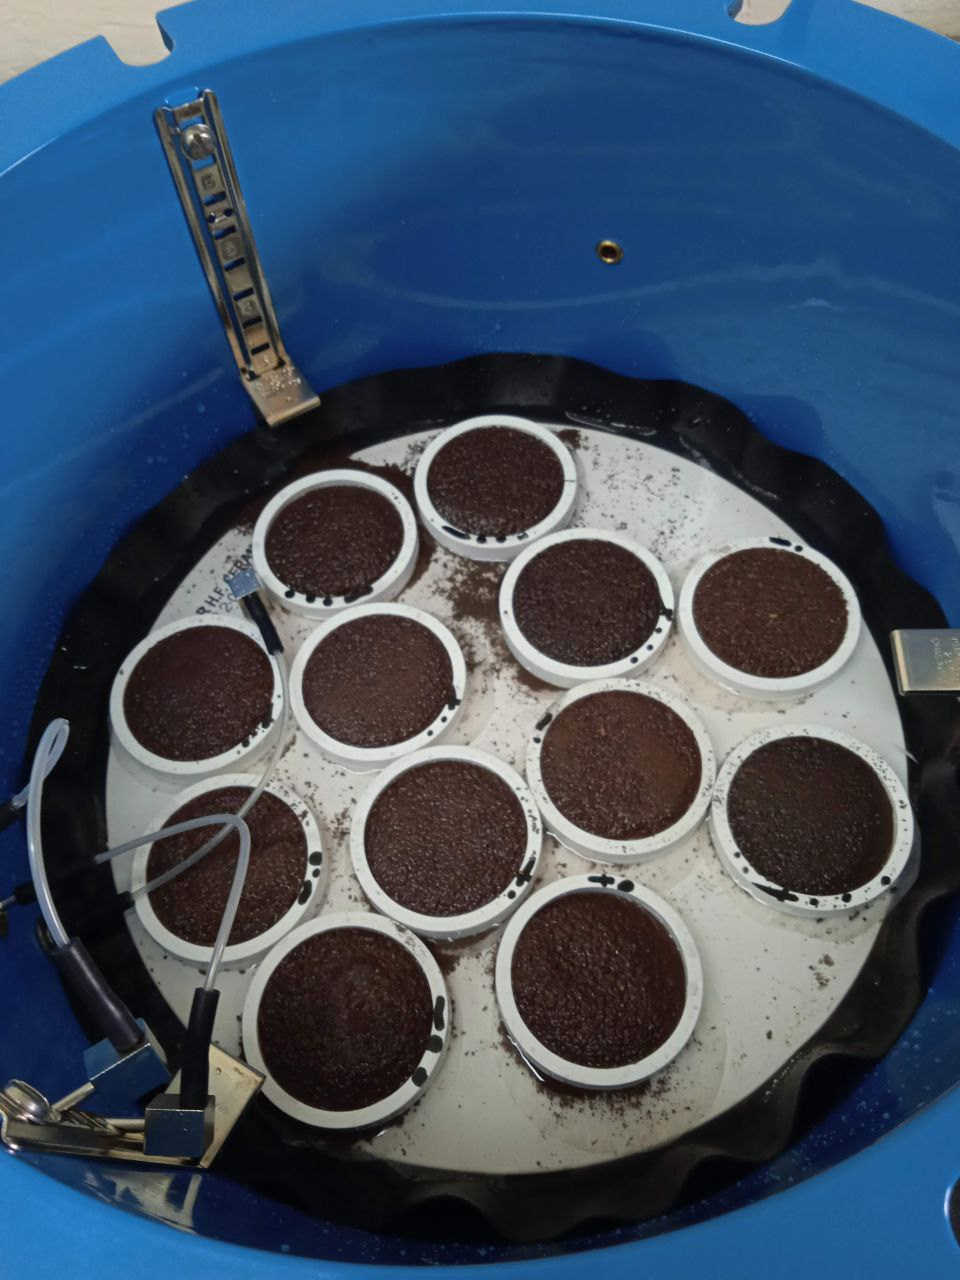

In [58]:
image_paths = ['./img/ollas.jpg', './img/ollas1.jpg', './img/ollas3.jpg']
image_width = '600px'
for image_path in image_paths:
    img = Image(filename=image_path, width=image_width)
    display(img)

##### Curva de retención de humedad

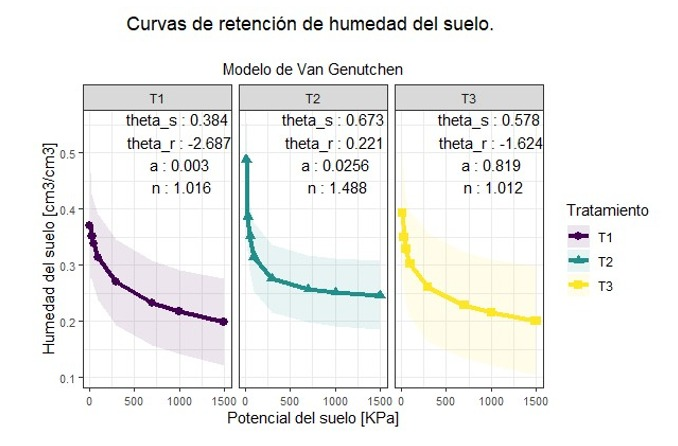

In [57]:
Image(filename='./img/curvas.jpeg')

# Indice de sequia a alta resolucion espacial

### Necesitamos data de suelos

Capacidad de campo (CC) y Punto de marchitz permanente (PMP)

In [54]:
theta_fc = 0.308
theta_pmp = 0.179

In [62]:

# downscaled_smap_cuenca = downscaled_smap_cuenca.to_dataset(name='theta')
downscaled_smap_cuenca['swdi'] = (downscaled_smap_cuenca['theta'] - theta_fc) / (theta_fc - theta_pmp)
swdi = downscaled_smap_cuenca[['swdi']]
swdi


<xarray.Dataset>
Dimensions:  (time: 213, y: 49, x: 42)
Coordinates:
  * y        (y) float64 -13.55 -13.55 -13.56 -13.56 ... -13.59 -13.59 -13.59
  * x        (x) float64 -71.87 -71.87 -71.87 -71.87 ... -71.84 -71.84 -71.84
    band     int32 1
  * time     (time) datetime64[ns] 2021-01-01 2021-01-04 ... 2022-07-28
Data variables:
    swdi     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [65]:
# plots

monthly_swdi = swdi.groupby('time.month').mean(dim='time')
monthly_swdi


<xarray.Dataset>
Dimensions:  (month: 12, y: 49, x: 42)
Coordinates:
  * y        (y) float64 -13.55 -13.55 -13.56 -13.56 ... -13.59 -13.59 -13.59
  * x        (x) float64 -71.87 -71.87 -71.87 -71.87 ... -71.84 -71.84 -71.84
    band     int32 1
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    swdi     (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [69]:
from scipy.ndimage import gaussian_filter

sigma = 1.0

smoothed_dataset = xr.Dataset()
for var_name, var_data in monthly_swdi.data_vars.items():
    smoothed_data = gaussian_filter(var_data.values, sigma=sigma)
    smoothed_dataset[var_name] = (('month', 'y', 'x'), smoothed_data)

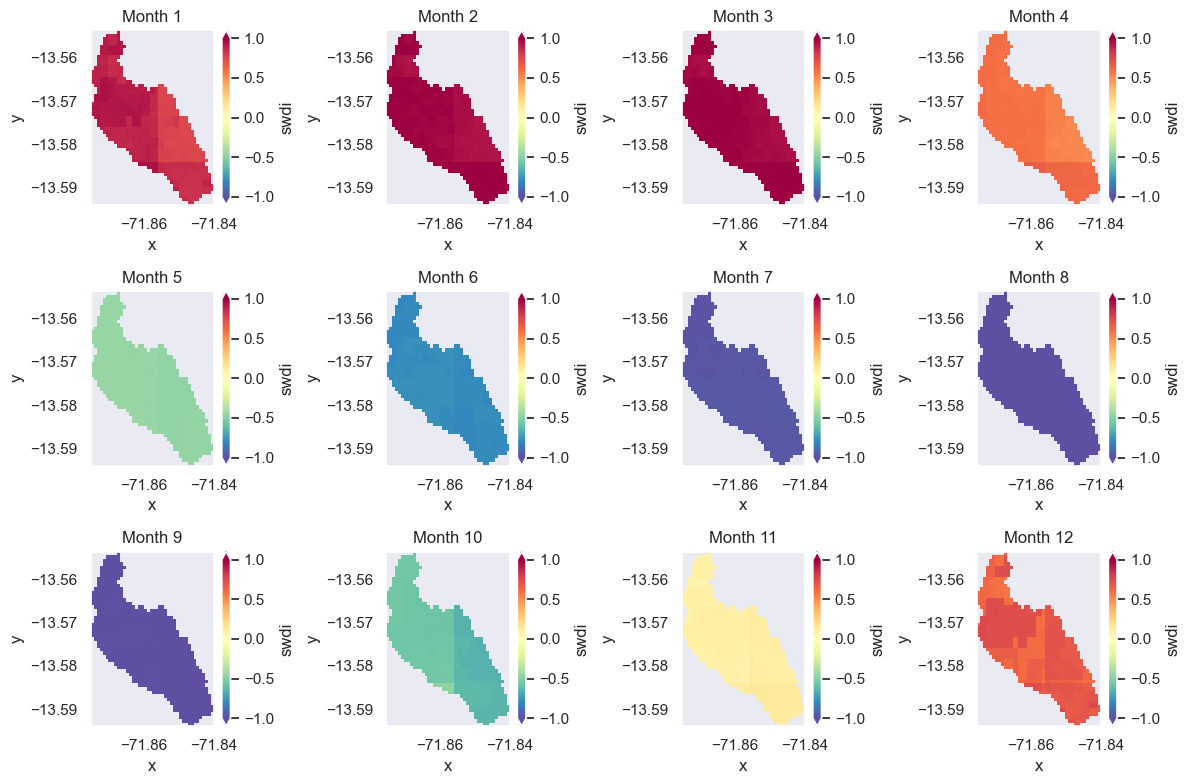

In [86]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for month in range(1, 13):

    swdi_month = monthly_swdi["swdi"].sel(month=month)
    

    row = (month - 1) // 4
    col = (month - 1) % 4
    
    swdi_month.plot.pcolormesh(
        ax=axes[row, col],
        vmin=-1,
        vmax=1,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    
    axes[row, col].set_title(f"Month {month}")

plt.tight_layout()
# plt.suptitle("Monthly SWDI Plots", fontsize=16)

# Show the plots
plt.show()